# Восстановление золота из руды

**Краткая суть**

Необходимо построить модель, которая будет прогнозировать коэффициент восстановления золота из золотосодержащей руды

**Описание**

Нужно подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Использовать будем данные с параметрами добычи и очистки. 
В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, необходимо их проверить


**Критерии оценки модели**

* нужно будет написать функциию для оценки модели sMAPE
* Значение метрики sMAPE на тестовой выборке должно быть наилучшим

**План выполнения проекта**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Импортируем нужные библиотеки и загрузим данные.

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor 
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

import optuna

import warnings
warnings.filterwarnings('ignore')

### Изучим данные

In [2]:
try:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    data_train = pd.read_csv('file_for_projects/gold_recovery_train_new.csv')
    data_test = pd.read_csv('file_for_projects/gold_recovery_test_new.csv')
    data_full = pd.read_csv('file_for_projects/gold_recovery_full_new.csv')

In [3]:
def looking_data(data):
    data.info(), 
    display(data.head())

In [1]:
#looking_data(data_train)

In [2]:
#looking_data(data_test)

In [3]:
#looking_data(data_full)

Весь датасет содержит 19 439 строк. Он разбит на два в соотношении 70(data_train) к 30(data_test). Имеются пропуски, которые нужно понять как заполнить.

### Проверим, что эффективность обогащения рассчитана правильно. Для этого напишем функцию, которая будет принимать на вход параметры из data_train и выдавать нам нужный результат

#### Определим функцию

In [7]:
def count_recovery(C, F, T):
    recovery = ((C * (F - T)) / (F * (C - T))) * 100 
    return recovery

#### выполним рассчёт

In [8]:
recovery = count_recovery(data_train['rougher.output.concentrate_au'], 
                          data_train['rougher.input.feed_au'], 
                          data_train['rougher.output.tail_au'])

In [9]:
print('МАЕ между recovery и признаком rougher.output.recovery:', 
      round(data_train['rougher.output.recovery'].abs().mean() - recovery.abs().mean(), 0))

МАЕ между recovery и признаком rougher.output.recovery: -0.0


Эффективность обогащения рассчитана правильно. МАЕ равна 0

### Посмотрим на разницу между data_test и data_train

- в data_test отсутствуют все признаки со значением блока output. По идее, они и не нужны в тесте, т к мы хотим подавать входные данные, по которым хотим получить оценку.
- в data_test отсутствуют признаки со значением блока calculation, по той же самое причине.
- оба параметра относятся к финальным данным, которые уже получены или рассчитаны

### Произведем предобработку

#### Определим функцию для заполнения пропусков. Поскольку у нас в условии сказано, что соседние по времени параметры часто похожи, заполним их в этом соответствии.

In [10]:
def fix_nan(data):
    for i in data.columns:
        data[i] = data[i].fillna(method='backfill')
    data.info()

In [4]:
#fix_nan(data_train)

In [5]:
#for i in data_test.columns: # тест заполним нолями, чтобы не "подсматривать в будущее"
#    data_test[i] = data_test[i].fillna(0)
#data_test.info()

In [6]:
#fix_nan(data_full)

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Работать будем с data_full

In [14]:
def checking_concentrate(a, b, c, d):
    a.hist(bins=90, 
           color='orange', 
           legend=True, 
           figsize=(15,9),
           alpha=0.5)
    b.hist(bins=90,
           color='red', 
           legend=True, 
           figsize=(15,9), 
           alpha=0.5)
    c.hist(bins=90, 
           color='blue', 
           legend=True, 
           figsize=(15,9),
           alpha=0.5),
    d.hist(bins=90, 
           color='grey', 
           legend=True, 
           figsize=(15,9),
           alpha=0.5)
    plt.title('График изменения концентрации вещества на различных этапах очистки')
    plt.show()
    

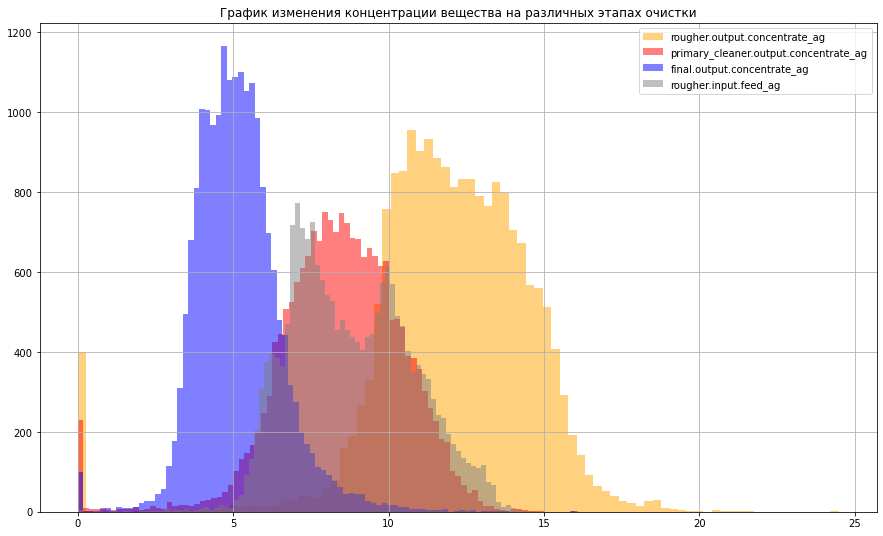

In [15]:
checking_concentrate(data_full['rougher.output.concentrate_ag'],
                    data_full['primary_cleaner.output.concentrate_ag'],
                    data_full['final.output.concentrate_ag'],
                    data_full['rougher.input.feed_ag'])

 Здесь мы можем наблюдать график концентрации серебра на различных этапах очистки.
 
- <span style="color:grey">серый</span> это начальный концентрат серебра
- <span style="color:orange">оранжевый</span> это черновой концентрат серебра
- <span style="color:red">красный</span> это концентрат серебра после первой очистки
- <span style="color:blue">синий</span> это финальный концентрат серебра


Как мы можем заметить, концентрация уменьшается от начального этапа к финальному. На графике видно, что концентрация серебра в сырье совпадает с концентрацией после первичной очистки. Имеются аномалии в районе 0, что может говорить нам о сбое измеряющего прибора

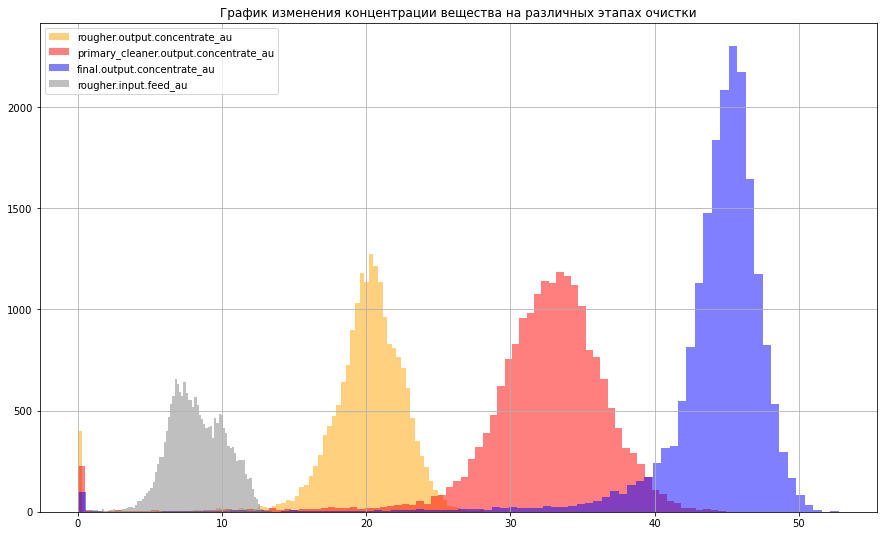

In [16]:
checking_concentrate(data_full['rougher.output.concentrate_au'],
                    data_full['primary_cleaner.output.concentrate_au'],
                    data_full['final.output.concentrate_au'],
                    data_full['rougher.input.feed_au'])

 Здесь мы можем наблюдать график концентрации серебра на различных этапах очиски.
- <span style="color:grey">серый</span> это начальный концентрат золота
- <span style="color:orange">оранжевый</span> это черновой концентрат золота
- <span style="color:red">красный</span> это концентрат золота после первой очистки
- <span style="color:blue">синий</span> это финальный концентрат золота


Как мы можем заметить, концентрация увеличивается от начального этапа к финальному. График сильно отличается от графика серебра, выделяются четкие разделения. Здесь тоже есть аномалия в районе 0, прибор сбоит.

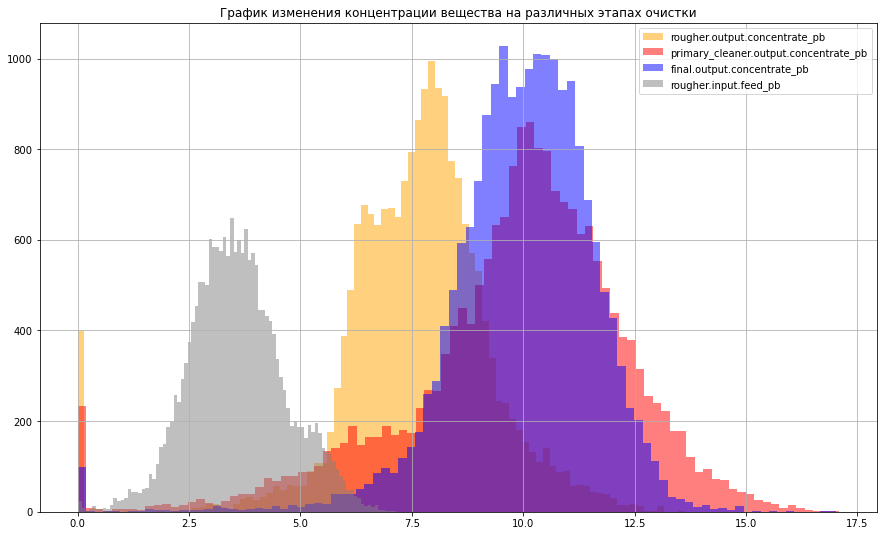

In [17]:
checking_concentrate(data_full['rougher.output.concentrate_pb'],
                    data_full['primary_cleaner.output.concentrate_pb'],
                    data_full['final.output.concentrate_pb'],
                    data_full['rougher.input.feed_pb'])

 Здесь мы можем наблюдать график концентрации свинца на различных этапах очиски.
- <span style="color:grey">серый</span> это начальный концентрат свинца 
- <span style="color:orange">оранжевый</span> это черновой концентрат свинца
- <span style="color:red">красный</span> это концентрат свинца после первой очистки
- <span style="color:blue">синий</span> это финальный концентрат свинца

Можно заметить, что какого-то явного изменения, как у золота или серебра, не происходит к завершению, но стоит отметить, что концентрация сокращается. Аномалии в районе 0 присутствуют

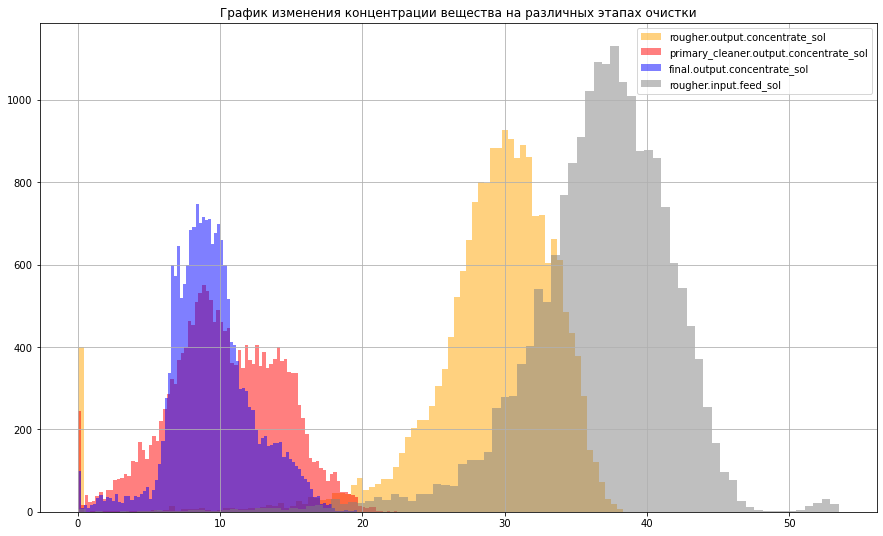

In [18]:
checking_concentrate(data_full['rougher.output.concentrate_sol'],
                    data_full['primary_cleaner.output.concentrate_sol'],
                    data_full['final.output.concentrate_sol'],
                    data_full['rougher.input.feed_sol'])

 Здесь мы можем наблюдать график концентрации прочих примесей на различных этапах очиски. Он для нас не важен, мы просто посмотрим на изменения
- <span style="color:grey">серый</span> это начальный концентрат прочих примесей 
- <span style="color:orange">оранжевый</span> это черновой концентрат прочих примесей
- <span style="color:red">красный</span> это концентрат прочих примесей после первой очистки
- <span style="color:blue">синий</span> это финальный концентрат прочих примесей

Как мы видим, примесей сильно много в черновом продукте, затем следует уменьшение, практически в 2 раза. И аномалии есть тоже

#### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

##### Создадим столбец с сумарной концентрацией веществ в сырье 

In [19]:
data_full['full_rougher.input'] = \
      data_full['rougher.input.feed_ag']\
    + data_full['rougher.input.feed_au']\
    + data_full['rougher.input.feed_pb']\
    + data_full['rougher.input.feed_sol']

##### Создадим столбец с сумарной концентрацией веществ в черновом концентрате

In [20]:
data_full['full_concentrate_rougher'] = \
      data_full['rougher.output.concentrate_ag']\
    + data_full['rougher.output.concentrate_au']\
    + data_full['rougher.output.concentrate_pb']\
    + data_full['rougher.output.concentrate_sol']

##### Создадим столбец с сумарной концентрацией веществ в финальном продукте

In [21]:
data_full['full_concentrate_output'] = \
      data_full['final.output.concentrate_ag']\
    + data_full['final.output.concentrate_au']\
    + data_full['final.output.concentrate_pb']\
    + data_full['final.output.concentrate_sol']

#### Построим график по нашим новым столбцам

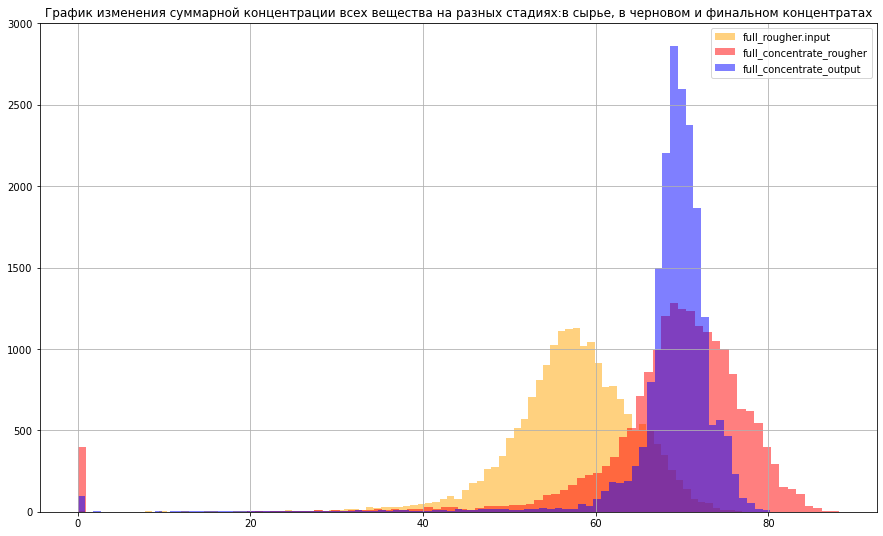

In [22]:
data_full['full_rougher.input'].hist(bins=90, 
                                     color='orange', 
                                     legend=True, 
                                     figsize=(15,9),
                                     alpha=0.5)
data_full['full_concentrate_rougher'].hist(bins=90,
                                           color='red', 
                                           legend=True, 
                                           figsize=(15,9), 
                                           alpha=0.5)
data_full['full_concentrate_output'].hist(bins=90, 
                                          color='blue', 
                                          legend=True, 
                                          figsize=(15,9),
                                          alpha=0.5),
plt.title('График изменения суммарной концентрации всех вещества на разных стадиях:' 
              'в сырье, в черновом и финальном концентратах')
plt.show()

 Здесь мы можем наблюдать график концентрации прочих примесей на различных этапах очиски. Он для нас не важен, мы просто посмотрим на изменения
 
- <span style="color:orange">оранжевый</span> это концентрат в сырье
- <span style="color:red">красный</span> это черновой концентрат 
- <span style="color:blue">синий</span> это финальный концентрат 

- График отображает нам четкие разделения между концентрацией в сырье и черовым концентратом, а дальше мы видим как у нас из черновой происходит "вытикание" финальной концентрации. Аномалии присутствуют.
- Исходя из графиков, можно сделать вывод, что мы можем избавиться от аномалий, т к эти данные не важны для нас. 

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

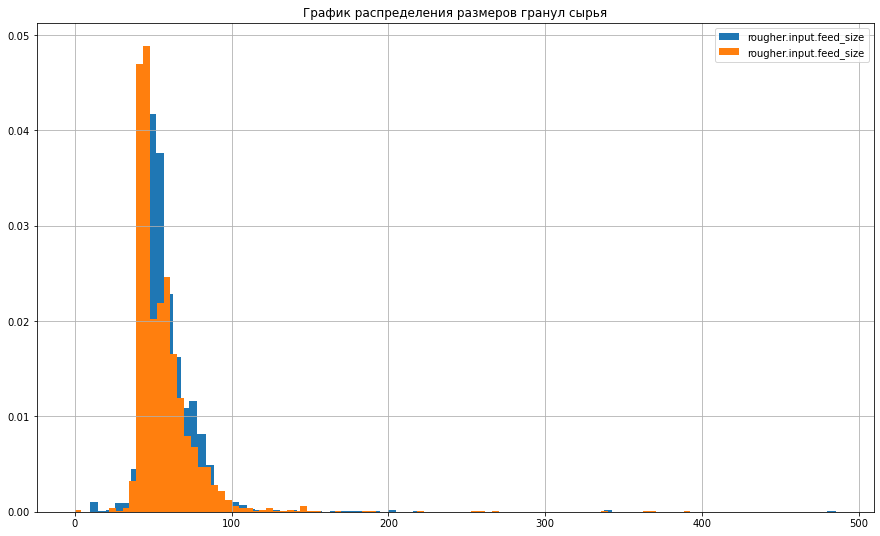

In [23]:
data_train['rougher.input.feed_size'].hist(bins=90, figsize=(15,9), legend=True, density=True)
data_test['rougher.input.feed_size'].hist(bins=90, figsize=(15,9), legend=True, density=True)
plt.title('График распределения размеров гранул сырья')
plt.show()

На графике выше отображено распределение размеров гранул сырья на двух выборках. Распределение не отличается.

- <span style="color:blue">синий</span> это размер гранул на обучающей выборке
- <span style="color:red">красный</span> это размер гранул на тестовой выборке

 

### Избавимся от аномалий

In [24]:
data_train = data_train[(data_train['rougher.output.concentrate_ag'] >= 2) & 
                        (data_train['primary_cleaner.output.concentrate_ag'] >= 2) &
                       (data_train['rougher.input.feed_ag'] >= 2)]

In [25]:
data_train = data_train[(data_train['rougher.output.concentrate_au'] >= 2) & 
                        (data_train['primary_cleaner.output.concentrate_au'] >= 2) &
                       (data_train['rougher.input.feed_au'] >= 2)]

In [26]:
data_train = data_train[(data_train['rougher.output.concentrate_pb'] >= 2) & 
                        (data_train['primary_cleaner.output.concentrate_pb'] >= 2) &
                       (data_train['rougher.input.feed_pb'] >= 2)]

In [27]:
data_train = data_train[(data_train['rougher.output.concentrate_sol'] >= 2) & 
                        (data_train['primary_cleaner.output.concentrate_sol'] >= 2) &
                       (data_train['rougher.input.feed_sol'] >= 2)]

## Модель

### Определим функцию для подсчёта нашей метрики

In [28]:
def sMAPE(targets, predictions): 
    summa = (abs(targets - predictions)) / ((abs(targets) + abs(predictions)) / 2)
    sMAPE = summa.sum() / len(summa) * 100
    return sMAPE

In [29]:
def sMAPE_main(sMAPE_rougher, sMAPE_final):
    sMAPE_main = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final
    return sMAPE_main

In [30]:
my_score = make_scorer(sMAPE, greater_is_better=False)

### Создадим тренировочный набор данных для прогнозирования обогащения чернового концентрата 

In [31]:
data_test = data_test.merge(data_full[['date','final.output.recovery', 'rougher.output.recovery']], on='date', how='left')

In [32]:
columns = [c for c in data_test.columns if "rougher" in c]
target_col = 'rougher.output.recovery'
df_tmp = data_train[columns]
X_rougher_t = df_tmp.drop(target_col, axis=1)
y_rougher_t = df_tmp[target_col]
X_rougher_t.shape, y_rougher_t.shape

((12565, 22), (12565,))

### Создадим тренировочный набор данных для прогнозирования обогащения финального концентрата 

In [33]:
columns = [c for c in data_test.columns]
target_col = 'final.output.recovery'
df_tmp = data_train[columns]
X_final_t = df_tmp.drop(['date', 'final.output.recovery'], axis=1)
y_final_t = df_tmp['final.output.recovery']
X_final_t.shape, y_final_t.shape

((12565, 53), (12565,))

### Создадим проверочный набор данных для прогнозирования обогащения чернового концентрата 

In [34]:
columns = [c for c in data_test.columns if "rougher" in c]
df_tmp = data_test[columns]
X_rougher = df_tmp.drop(['rougher.output.recovery'], axis=1)
y_rougher = df_tmp['rougher.output.recovery']
X_rougher.shape, y_rougher.shape

((5290, 22), (5290,))

### Создадим проверочный набор данных для прогнозирования обогащения финального концентрата 

In [35]:
X_final = data_test.drop(['date', 'final.output.recovery'], axis=1)
y_final = data_test['final.output.recovery']
X_final.shape, y_final.shape

((5290, 53), (5290,))

### Нормализуем данные

In [36]:
scaler_rougher = StandardScaler()
scaler_rougher.fit_transform(X_rougher_t)
scaler_final = StandardScaler()
scaler_final.fit_transform(X_final_t)

array([[-0.27873298,  0.33412211, -0.14055168, ..., -0.93227406,
        -2.67034619,  0.29295718],
       [-0.31800229,  0.38435545, -0.14055168, ..., -0.95876178,
        -2.50634132,  0.25810679],
       [-0.36657778,  0.68943274, -0.14055168, ..., -0.95351397,
        -2.55076847,  0.25798133],
       ...,
       [-0.85392871, -0.31584847, -1.37863693, ...,  0.07875529,
         0.15544129,  0.52785791],
       [-1.03609323, -0.30715935, -1.37863693, ...,  0.08275483,
         0.17962927,  0.65534031],
       [-1.13360029, -0.27880794, -1.37863693, ...,  0.07866014,
         0.21846888,  0.61012531]])

In [37]:
scaler_rougher.transform(X_rougher)
scaler_final.transform(X_final)

array([[ 1.96850229,  1.78912652,  1.22959588, ...,  1.24135749,
         0.2044423 ,  0.67316657],
       [ 2.09176616,  1.78743776,  1.22959588, ...,  0.94946071,
         0.2014621 ,  0.42232985],
       [ 2.08820886,  1.15859649,  0.74536715, ...,  0.94511881,
         0.17970814,  0.46490078],
       ...,
       [ 0.90365721,  2.08837838,  1.2130877 , ..., -1.82726135,
         0.25643622,  1.07169814],
       [ 1.13349619,  1.9224778 ,  1.2130877 , ..., -1.82195967,
         0.19239219,  1.01647874],
       [ 1.18342133,  1.78994363,  1.2130877 , ..., -1.82611972,
         0.17585157,  0.82920444]])

### Импортируем модели

In [38]:
linR = LinearRegression()
rfr = RandomForestRegressor(random_state=22, max_depth=1)
dtf = DecisionTreeRegressor(random_state=22, max_depth=1)
cat = CatBoostRegressor(random_seed=22)

### Сделаем предсказания для rougher.output.recovery 

In [39]:
scor_linR = cross_val_score(linR, X_rougher_t, y_rougher_t, cv=7, scoring=my_score).mean()
np.round(scor_linR, 1)

-5.8

In [40]:
scor_rfr = cross_val_score(rfr, X_rougher_t, y_rougher_t, cv=7, scoring=my_score).mean()
np.round(scor_rfr, 1)

-7.7

In [41]:
scor_dtf = cross_val_score(dtf, X_rougher_t, y_rougher_t, cv=7, scoring=my_score).mean()
np.round(scor_dtf, 1)

-7.6

In [7]:
scor_cat = cross_val_score(cat, X_rougher_t, y_rougher_t, cv=7, scoring=my_score).mean()
np.round(scor_cat, 1)

В целом, всё достаточно ровно, но лучше всех с задачей справляется линейная регрессия. Cреднее cимметричное абсолютное процентное отклонение для линейной регрессии равно 5.8% 

### Сделаем предсказания для final.output.recovery 

In [46]:
linR_e = LinearRegression()
rfr_e = RandomForestRegressor(random_state=22, max_depth=1)
dtf_e = DecisionTreeRegressor(random_state=22, max_depth=1)
cat_e = CatBoostRegressor(random_seed=22, verbose=False)

In [44]:
scor_linR_e = cross_val_score(linR_e, X_final_t, y_final_t, cv=7, scoring=my_score).mean()
np.round(scor_linR_e, 1) * (-1)

9.7

In [45]:
scor_rfr_e = cross_val_score(rfr_e, X_final_t, y_final_t, cv=7, scoring=my_score).mean()
np.round(scor_rfr_e, 1) * (-1)

8.8

In [47]:
scor_dtf_e = cross_val_score(dtf_e, X_final_t, y_final_t, cv=7, scoring=my_score).mean()
np.round(scor_dtf_e, 1) * (-1)

9.0

In [48]:
scor_cat_e = cross_val_score(cat_e, X_rougher_t, y_rougher_t, cv=7, scoring=my_score).mean()
np.round(scor_cat_e, 1) * (-1)

6.2

Здесь тоже значение метрики для разных моделей не сильно разнится. Но здесь чуть лучше справляется случайный лес.

<b>Изменения:</b> Для проверки на тесте будем использовать линейную регрессию.
</div>

### Подберем гиперпараметры для линейной регрессии

In [49]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(linR,parameters, cv=5, scoring=make_scorer(sMAPE, greater_is_better=False))
grid.fit(X_rougher_t, y_rougher_t)
best_estimator = grid.best_estimator_
print(best_estimator)
print(grid.best_score_)

LinearRegression(normalize=True)
-6.367251145442419


In [50]:
parameters2 = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(linR_e,parameters2, cv=5, scoring=make_scorer(sMAPE, greater_is_better=False))
grid.fit(X_final_t, y_final_t)
best_estimator = grid.best_estimator_
print(best_estimator)
print(grid.best_score_)

LinearRegression(fit_intercept=False, normalize=True)
-8.532278379850974


In [57]:
def objective_cat(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 1300),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15)
    }
        
    cat_e.set_params(**params)
    
    scor_cat_e = cross_val_score(cat_e, X_rougher_t, y_rougher_t, cv=7, scoring=my_score)

    
    #model = CatBoostRegressor(loss_function=my_score, random_state=42,)
            
    return scor_cat_e.mean()

In [ ]:
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=5)
study_cat.best_params

[I 2022-12-30 13:45:41,173] A new study created in memory with name: no-name-3e4f1455-ff41-448a-b675-780614f3bb41


### Проверим модель на тесте для черновой концентрации

In [174]:
linR = LinearRegression(fit_intercept=False, normalize=True)
linR = linR.fit(X_rougher_t, y_rougher_t)
predict_rougher = linR.predict(X_rougher)
score_rougher = sMAPE(y_rougher, predict_rougher)

### Проверим модель на тесте для финальной концентрации

In [175]:
linR_e = LinearRegression(fit_intercept=False, normalize=True)
linR_e = linR_e.fit(X_final_t, y_final_t)
predict_final = linR_e.predict(X_final)
score_final = sMAPE(y_final, predict_final)

### Проверим модель на адекватность. Сравним её предсказания черновой концентрации с константной

In [176]:
dummy = DummyRegressor(strategy="mean").fit(X_rougher_t, y_rougher_t)
predict_dummy = dummy.predict(X_rougher)
score_dummy_rougher = sMAPE(y_rougher, predict_dummy)

### Проверим модель на адекватность. Сравним её предсказания финальной концентрации с константной

In [177]:
dummy = DummyRegressor(strategy="mean").fit(X_final_t, y_final_t)
predict_dummy = dummy.predict(X_final)
score_dummy_final = sMAPE(y_final, predict_dummy)

In [178]:
print('Cреднее cимметричное абсолютное процентное отклонение ' 
       'для прогнозирования чернового концентрата:', np.round(score_rougher, 1),'%')
print('Cреднее cимметричное абсолютное процентное отклонение ' 
       'для прогнозирования чернового концентрата константной модели:', np.round(score_dummy_rougher, 1),'%')
print('Cреднее cимметричное абсолютное процентное отклонение ' 
       'для прогнозирования финального концентрата:', np.round(score_final, 1),'%')
print('Cреднее cимметричное абсолютное процентное отклонение ' 
       'для прогнозирования финального концентрата константной модели:', np.round(score_dummy_final, 1),'%')

Cреднее cимметричное абсолютное процентное отклонение для прогнозирования чернового концентрата: 9.1 %
Cреднее cимметричное абсолютное процентное отклонение для прогнозирования чернового концентрата константной модели: 8.8 %
Cреднее cимметричное абсолютное процентное отклонение для прогнозирования финального концентрата: 10.8 %
Cреднее cимметричное абсолютное процентное отклонение для прогнозирования финального концентрата константной модели: 10.0 %


### Посчитаем итоговую метрику

In [179]:
MAPE = sMAPE_main(score_rougher, score_final)
print('Финальное среднее cимметричное абсолютное процентное отклонение:', np.round(MAPE, 1),'%')

Финальное среднее cимметричное абсолютное процентное отклонение: 10.4 %


# Вывод:

1. Нам нужно было подготовить прототип модели машинного обучения для компании «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

2. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, используя данные с параметрами добычи и очистки. 

3. У нас было полный файл с данными, и уже готовые обучающая и тестовая выборки. В файлах были пропуски и аномалии, которые были нами обработаны.

4. Мы провели исследовательский анализ данных, по результатам которого была получена следующая информация: 
- концентрация серебра уменьшается от начального этапа к финальному. Также график показал нам, что концентрация серебра в сырье совпадает с концентрацией после первичной очистки, либо так и должно быть, либо что-то не так с прибором
- концентрация золота увеличивается от начального этапа к финальному, на графике были четкие разделения между этапами. 
- у свинца всё было не так как у золота или серебра. Каких-то сильных изменений не происходит к завершению, концентрация просто сокращается
- концентрация примесей сокращается практически в 2 раза к финальному этапу

5. Далее мы написали функцию для проверки качества наших моделей и ,собственно, начали обучение. Модели использовались DecisionTreeRegressor, RandomForestRegressor, LinearRegression. Кроссвалидацией прошлись по каждой и выявили, что в среднем, разница не сильно большая в прогнозировании ответов, примерно 2 процента. 

6. С помощью GridSearchCV подобрали параметры для LinearRegression и выполнили финальную проверку модели на тестовых данных. Результат получили:
- для предсказания rougher.output.recovery - 9.1%
- для предсказания final.output.recovery - 10.8%

7. При проверке моделей на адекватность, сравнивали её с константной моделью DummyRegressor. DummyRegressor предсказал:
- для предсказания rougher.output.recovery - 8.8%
- для предсказания final.output.recovery - 10.0%




8. Финальное среднее cимметричное абсолютное процентное отклонение для LinearRegression: 10.4 %